## Data Exploration

In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

/opt/conda/envs/zhangjx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.0
0.13.0
cpu


In [2]:
bundle = torchaudio.pipelines.HUBERT_BASE

In [3]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [4]:
import os
os.listdir('./EMOVO/f1')

['rab-f1-d1.wav',
 'dis-f1-n3.wav',
 'rab-f1-b3.wav',
 'sor-f1-d1.wav',
 'pau-f1-d1.wav',
 'pau-f1-b3.wav',
 'pau-f1-l3.wav',
 'rab-f1-n3.wav',
 'gio-f1-n2.wav',
 'gio-f1-n3.wav',
 'rab-f1-l1.wav',
 'gio-f1-l1.wav',
 'sor-f1-n5.wav',
 'pau-f1-b2.wav',
 'tri-f1-d2.wav',
 'tri-f1-n1.wav',
 'sor-f1-b1.wav',
 'gio-f1-n5.wav',
 'dis-f1-d1.wav',
 'rab-f1-l2.wav',
 'gio-f1-b2.wav',
 'tri-f1-n2.wav',
 'neu-f1-n5.wav',
 'sor-f1-l1.wav',
 'pau-f1-n2.wav',
 'dis-f1-n1.wav',
 'sor-f1-n1.wav',
 'neu-f1-d1.wav',
 'tri-f1-l2.wav',
 'neu-f1-b3.wav',
 'neu-f1-l3.wav',
 'neu-f1-n3.wav',
 'sor-f1-l2.wav',
 'gio-f1-l3.wav',
 'tri-f1-d1.wav',
 'pau-f1-n4.wav',
 'sor-f1-n2.wav',
 'rab-f1-n2.wav',
 'dis-f1-n5.wav',
 'sor-f1-n4.wav',
 'gio-f1-n1.wav',
 'pau-f1-n3.wav',
 'gio-f1-b1.wav',
 'tri-f1-n3.wav',
 'rab-f1-b2.wav',
 'dis-f1-n4.wav',
 'sor-f1-l3.wav',
 'gio-f1-l2.wav',
 'pau-f1-n1.wav',
 'dis-f1-b3.wav',
 'sor-f1-n3.wav',
 'sor-f1-l4.wav',
 'tri-f1-b3.wav',
 'pau-f1-l1.wav',
 'tri-f1-b1.wav',
 'dis-f1-d

In [5]:
sample_file = './EMOVO/f1/dis-f1-n3.wav'
sample_wave, sr = torchaudio.load(sample_file)

In [6]:
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

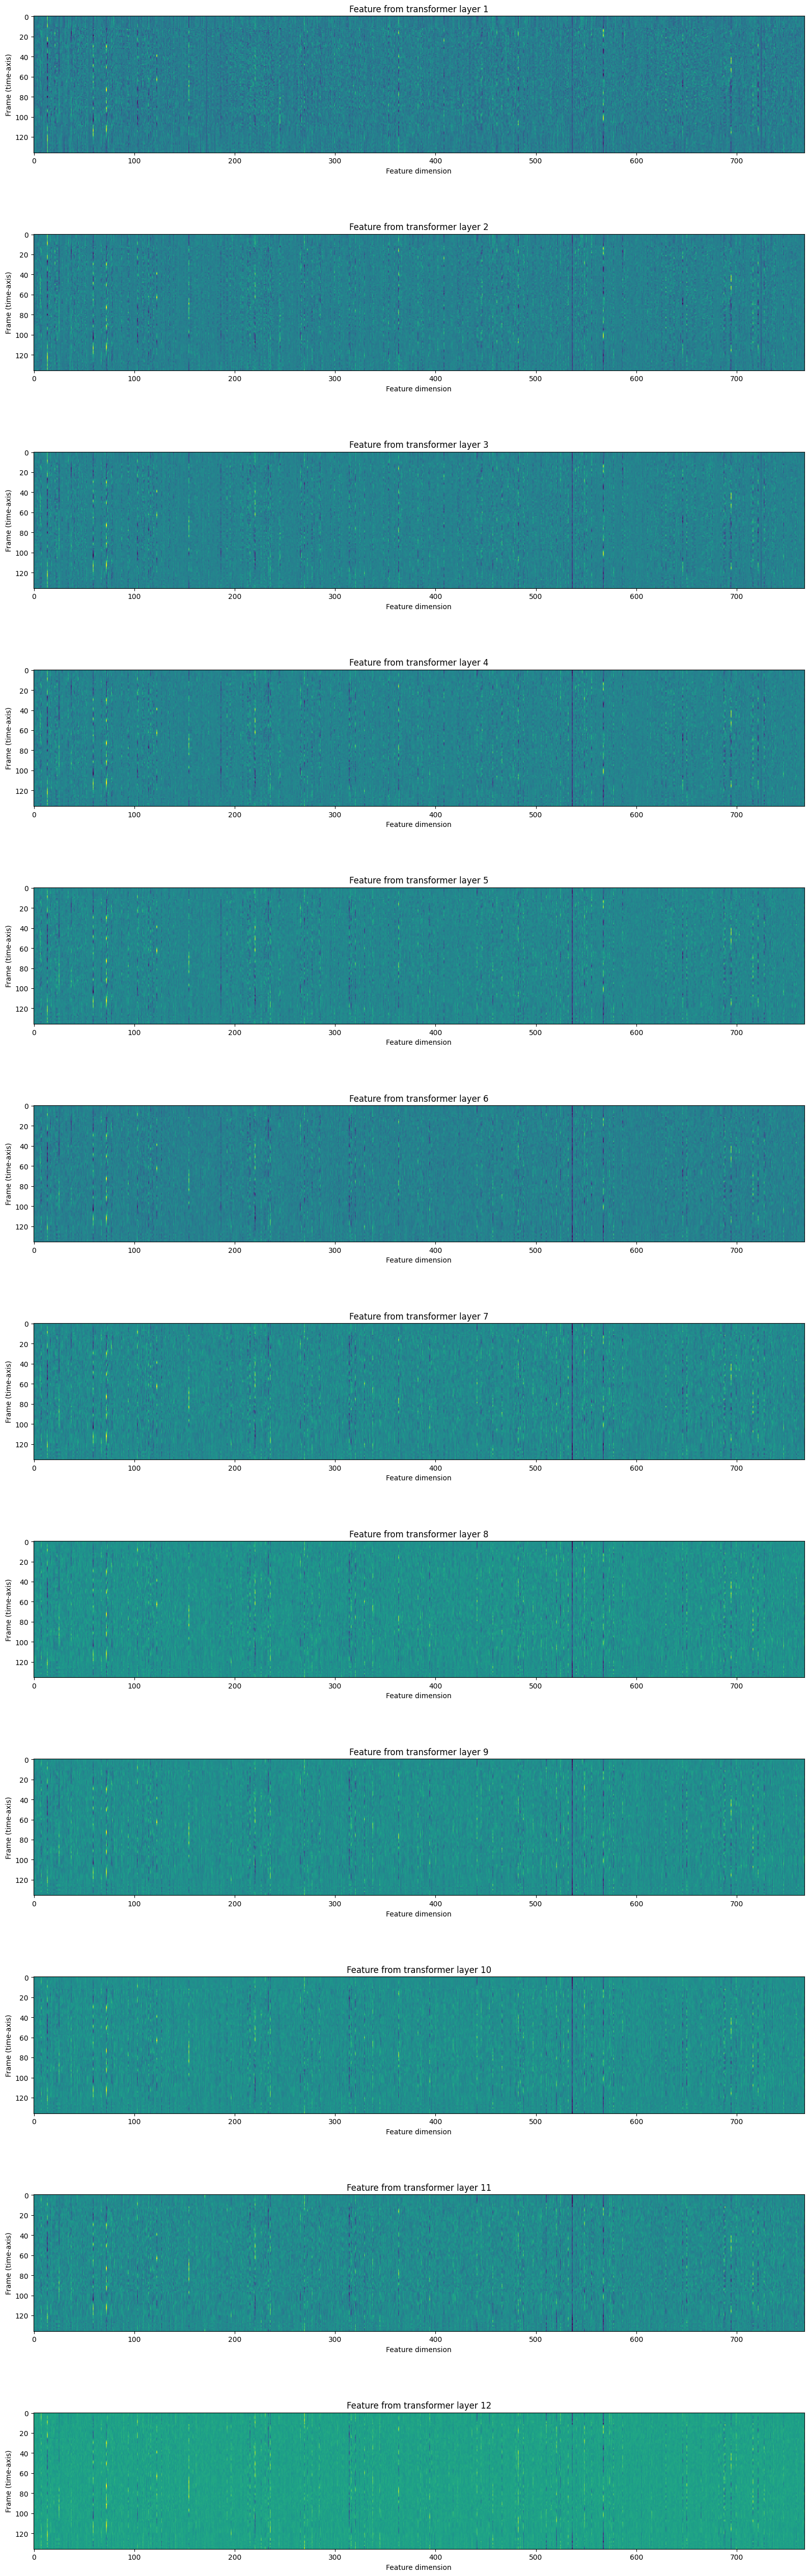

In [8]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
features[0].shape

torch.Size([2, 136, 768])

In [10]:
features[0][0].shape

torch.Size([136, 768])

## Feature Preparation

In [11]:
import os

data_path = './EMOVO/'
folders = ['f1', 'f2', 'f3', 'm1', 'm2', 'm3']
audios = []
labels = []
for folder in folders:
    dir_path = data_path + folder + '/'
    for file in os.listdir(dir_path):
        if 'wav' not in file:
            continue
        file_path = dir_path + file
        label = file.split('-')[0]
        labels.append(label)
        wave, sr = torchaudio.load(file_path)
        wave = wave.to(device)
        if sr != bundle.sample_rate:
            wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
        with torch.inference_mode():
            features, _ = model.extract_features(wave)
        audios.append(features[0][0])

In [12]:
audios[0].shape

torch.Size([80, 768])

In [13]:
audios[0].size(0)

80

In [14]:
audios[-1].shape

torch.Size([206, 768])

In [15]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [16]:
categories = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'dis': 0, 'gio': 1, 'neu': 2, 'pau': 3, 'rab': 4, 'sor': 5, 'tri': 6}

In [17]:
def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

In [19]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 285, 768])
1 torch.Size([64, 610, 768])
2 torch.Size([64, 450, 768])
3 torch.Size([64, 699, 768])
4 torch.Size([64, 517, 768])
5 torch.Size([64, 327, 768])
6 torch.Size([64, 343, 768])
7 torch.Size([22, 240, 768])


## Data Visualization

In [20]:
audios = [torch.mean(audio, dim=0).tolist() for audio in audios]

In [21]:
len(audios[0])

768

In [22]:
num_to_cate = {'gio':'happy', 'neu':'neutral', 'rab':'angry', 'tri':'sad'}
cate_audios = []
cate_labels = []
for i in range(len(audios)):
    if labels[i] in num_to_cate:
        cate_audios.append(audios[i])
        cate_labels.append(num_to_cate[labels[i]])

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(cate_audios)

/opt/conda/envs/zhangjx/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/zhangjx/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:xlabel='comp1', ylabel='comp2'>

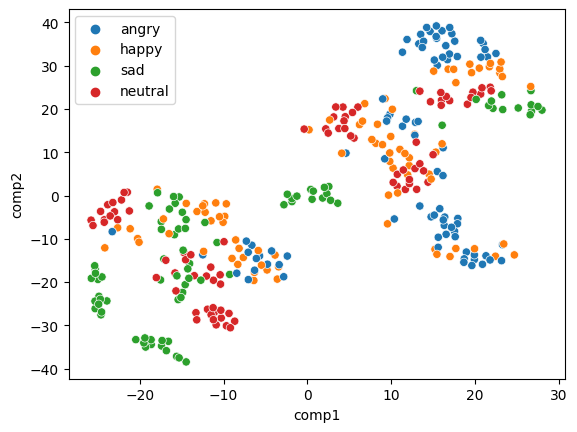

In [24]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(output, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=cate_labels, data=df)

## CNN

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [26]:
from torchsummary import summary

model = ICASSP3CNN(768, bidirectional=True)

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
model_path = './model_checkpoints/wav2vec_base.pth'

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  3%|█████▌                                                                                                                                                               | 1/30 [11:50<5:43:29, 710.68s/it]

epoch:1, train accu:0.2383, train loss:1.84, valid accu:0.3475, valid loss:1.86


  7%|███████████                                                                                                                                                          | 2/30 [20:19<4:36:09, 591.76s/it]

epoch:2, train accu:0.4702, train loss:1.37, valid accu:0.3814, valid loss:1.63


 10%|████████████████▌                                                                                                                                                    | 3/30 [28:31<4:05:54, 546.48s/it]

epoch:3, train accu:0.5787, train loss:1.10, valid accu:0.4661, valid loss:1.44


 13%|██████████████████████                                                                                                                                               | 4/30 [36:06<3:41:08, 510.33s/it]

epoch:4, train accu:0.6681, train loss:0.89, valid accu:0.5254, valid loss:1.21


 17%|███████████████████████████▌                                                                                                                                         | 5/30 [43:19<3:20:56, 482.26s/it]

epoch:5, train accu:0.7191, train loss:0.79, valid accu:0.4492, valid loss:1.32


 20%|█████████████████████████████████                                                                                                                                    | 6/30 [50:00<3:01:51, 454.64s/it]

epoch:6, train accu:0.7702, train loss:0.61, valid accu:0.6271, valid loss:0.97


 23%|██████████████████████████████████████▌                                                                                                                              | 7/30 [57:24<2:52:59, 451.27s/it]

epoch:7, train accu:0.8170, train loss:0.52, valid accu:0.6017, valid loss:1.11


 27%|███████████████████████████████████████████▍                                                                                                                       | 8/30 [1:04:43<2:43:58, 447.19s/it]

epoch:8, train accu:0.8383, train loss:0.46, valid accu:0.6271, valid loss:1.07


 30%|████████████████████████████████████████████████▉                                                                                                                  | 9/30 [1:11:29<2:32:06, 434.58s/it]

epoch:9, train accu:0.8723, train loss:0.34, valid accu:0.5932, valid loss:1.13


 33%|██████████████████████████████████████████████████████                                                                                                            | 10/30 [1:18:53<2:25:46, 437.33s/it]

epoch:10, train accu:0.8809, train loss:0.33, valid accu:0.6186, valid loss:1.28


 37%|███████████████████████████████████████████████████████████▍                                                                                                      | 11/30 [1:26:16<2:19:01, 439.01s/it]

epoch:11, train accu:0.8915, train loss:0.27, valid accu:0.6102, valid loss:1.31


 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 12/30 [1:33:16<2:10:01, 433.43s/it]

epoch:12, train accu:0.9234, train loss:0.23, valid accu:0.6610, valid loss:0.96


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                           | 13/30 [1:40:35<2:03:13, 434.94s/it]

epoch:13, train accu:0.9574, train loss:0.13, valid accu:0.6695, valid loss:1.14


 47%|███████████████████████████████████████████████████████████████████████████▌                                                                                      | 14/30 [1:47:20<1:53:34, 425.89s/it]

epoch:14, train accu:0.9362, train loss:0.19, valid accu:0.6102, valid loss:1.33


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 15/30 [1:54:11<1:45:24, 421.62s/it]

epoch:15, train accu:0.8957, train loss:0.35, valid accu:0.6017, valid loss:1.42


 53%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 16/30 [2:01:07<1:37:56, 419.77s/it]

epoch:16, train accu:0.9021, train loss:0.26, valid accu:0.6102, valid loss:1.44


 57%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 17/30 [2:07:23<1:28:07, 406.72s/it]

epoch:17, train accu:0.9553, train loss:0.15, valid accu:0.6525, valid loss:1.08


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 18/30 [2:14:11<1:21:22, 406.91s/it]

epoch:18, train accu:0.9660, train loss:0.13, valid accu:0.6356, valid loss:1.19


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 19/30 [2:21:14<1:15:29, 411.76s/it]

epoch:19, train accu:0.9702, train loss:0.09, valid accu:0.7119, valid loss:0.94


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 20/30 [2:28:23<1:09:29, 416.92s/it]

epoch:20, train accu:0.9787, train loss:0.09, valid accu:0.6864, valid loss:1.12


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 21/30 [2:35:27<1:02:51, 419.01s/it]

epoch:21, train accu:0.9851, train loss:0.05, valid accu:0.7203, valid loss:1.04


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 22/30 [2:42:27<55:54, 419.31s/it]

epoch:22, train accu:0.9851, train loss:0.04, valid accu:0.7203, valid loss:1.19


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 23/30 [2:48:51<47:41, 408.75s/it]

epoch:23, train accu:0.9936, train loss:0.03, valid accu:0.6780, valid loss:1.26


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 24/30 [2:55:32<40:39, 406.56s/it]

epoch:24, train accu:0.9979, train loss:0.01, valid accu:0.6949, valid loss:1.33


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 25/30 [3:02:03<33:29, 401.89s/it]

epoch:25, train accu:0.9979, train loss:0.01, valid accu:0.6949, valid loss:1.38


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 26/30 [3:08:56<27:00, 405.24s/it]

epoch:26, train accu:1.0000, train loss:0.00, valid accu:0.6949, valid loss:1.33


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 27/30 [3:15:25<20:01, 400.42s/it]

epoch:27, train accu:1.0000, train loss:0.00, valid accu:0.7119, valid loss:1.31


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 28/30 [3:22:31<13:35, 407.85s/it]

epoch:28, train accu:1.0000, train loss:0.00, valid accu:0.7119, valid loss:1.29


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 29/30 [3:29:32<06:52, 412.07s/it]

epoch:29, train accu:1.0000, train loss:0.00, valid accu:0.7203, valid loss:1.27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [3:36:27<00:00, 432.93s/it]

epoch:30, train accu:1.0000, train loss:0.00, valid accu:0.7034, valid loss:1.26


In [29]:
model_path = './model_checkpoints/hubert_base.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

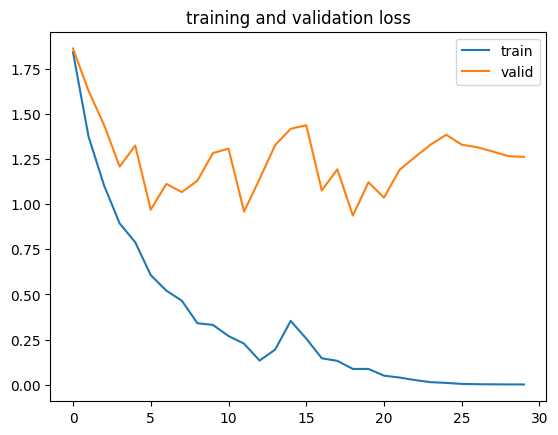

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

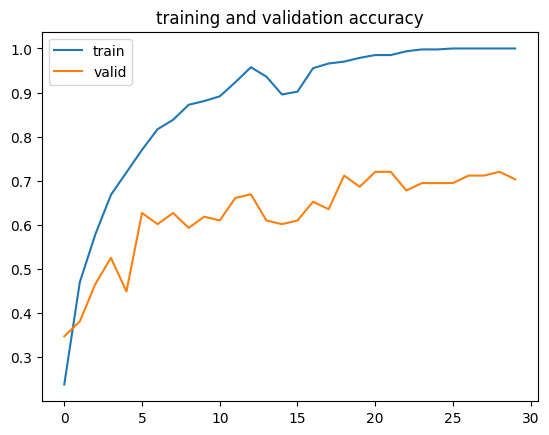

In [31]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [32]:
import pandas as pd
from datetime import datetime

now = datetime.now()

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 'valid loss':valid_losses, 'train accu':train_accuracies, 'valid_accu':valid_accuracies})
metadata.to_csv(f'./model_checkpoints/model_hubertbase.csv ', index=False)

